In [2]:
import numpy as np
from scipy import fftpack as fp
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


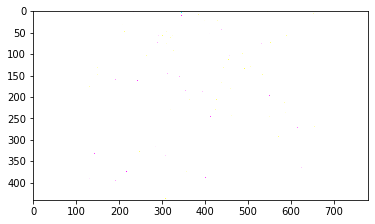

In [7]:
from skimage import color, io
i1 = io.imread('rektorat_ui.jpeg')
Ft = fp.fft2(i1);
f2 = abs(Ft)
plt.imshow(f2, cmap='gray'); plt.show();